In [604]:
import statistics
import math
import random
from matplotlib import pyplot as plt

## Population generation

Agent is an arithmetic expression constructed of numbers and symbols specified below.

Each number can be used `max_number_use` times, therefore the expression can contain from `1` to `len(numbers)*max_number_use` numbers.

After each number there is a symbol from `symbols`. But the symbol after the last number is ignored, but may be in future generations like an unexpressed gene in human genome. That decision was made primarly to make permutation like crossover easier to implement.

In [679]:
numbers = ['10', '25', '100', '5', '3']
symbols = ['+', '-', '*', '/']

max_number_use = 1
min_numbers_in_expresion = 1

target_value = 2512

In [318]:
def generate_agent():
    n_numbers = random.randint(min_numbers_in_expresion, len(numbers)*max_number_use)
    selected_numbers = random.sample(numbers*max_number_use, n_numbers)
    return [(number, random.choice(symbols)) for number in selected_numbers]

def agent_to_expression(agent):
        expression = "".join(n + s for i, (n, s) in enumerate(agent))
        return expression[:-1] # remove last operator
    
def evaluate_agent(agent):
    expression = agent_to_expression(agent)
    if len(expression) == 0: return 0
    else: return eval(expression)

def agent_to_string(agent):
    return f"{agent_to_expression(agent)} = {evaluate_agent(agent):.2f}"


Here are some randomly generated agents:

In [316]:
for i in range(20):
    a = generate_agent()
    print(agent_to_string(a))

3/5*10+100*25 = 2506.00
25-3/10*5/100 = 24.98
10+25*3/100/5 = 10.15
10/25/5*100-3 = 5.00
3/10-100+25-5 = -79.70
5+10*100/3+25 = 363.33
25/100/10+3+5 = 8.03
3-10*100/25/5 = -5.00
100+25/3*5*10 = 516.67
10*100*5*25/3 = 41666.67
10+3*100/25+5 = 27.00
10+25+3-5+100 = 133.00
100-5-25*3-10 = 10.00
10*5/100-3-25 = -27.50
3+10-5+100*25 = 2508.00
10-5*25/100*3 = 6.25
3+25*5-100/10 = 118.00
5*100*3+10-25 = 1485.00
25*3-10*5-100 = -75.00
5-100/25+10*3 = 31.00


## Fittnes

In [322]:
def fittnes(agent):
    return -abs(evaluate_agent(agent) - target_value)

## Mutation

In [497]:
agent = generate_agent()
print(agent)

[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-')]


In [494]:
def mutation_change_symbol(agent):
    a = agent.copy()
    i = random.randrange(len(a))
    number, _ = a[i]
    a[i] = (number, random.choice(symbols))
    
    return a

In [498]:
print(agent)
print(mutation_change_symbol(agent))

[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-')]
[('10', '*'), ('3', '+'), ('100', '+'), ('5', '/')]


In [501]:
def mutation_change_number(agent):
    a = agent.copy()
    agent_numbers = [number for number, _ in a]
    # choose numbers that can be added without violating `max_number_use`
    candidate_numbers = list(filter(lambda n: agent_numbers.count(n) < max_number_use, numbers))
    if len(candidate_numbers) == 0: return a
    i = random.randrange(len(a))
    _, symbol = a[i]
    a[i] = (random.choice(candidate_numbers), symbol)
    
    return a

In [503]:
print(agent)
print(mutation_change_number(agent))

[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-')]
[('10', '*'), ('25', '+'), ('100', '+'), ('5', '-')]


In [504]:
def mutation_add_element(agent):
    a = agent.copy()
    agent_numbers = [number for number, _ in a]
    # choose numbers that can be added without violating `max_number_use`
    candidate_numbers = list(filter(lambda n: agent_numbers.count(n) < max_number_use, numbers))
    if len(candidate_numbers) == 0: return a
    a.insert(random.randint(0, len(a)), (random.choice(candidate_numbers), random.choice(symbols)))
    
    return a

In [506]:
print(agent)
print(mutation_add_element(agent))

[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-')]
[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-'), ('25', '-')]


In [507]:
def mutation_remove_element(agent):
    a = agent.copy()
    if len(a) <= 1: return a # nothing to remove
    del a[random.randrange(len(a))]
    
    return a

In [508]:
print(agent)
print(mutation_remove_element(agent))

[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-')]
[('3', '+'), ('100', '+'), ('5', '-')]


In [509]:
def mutation(agent):
    mutation_type = random.randint(1, 4)
    if mutation_type == 1:
        return mutation_change_symbol(agent)
    if mutation_type == 2:
        return mutation_change_number(agent)
    if mutation_type == 3:
        return mutation_add_element(agent)
    if mutation_type == 4:
        return mutation_remove_element(agent)

In [510]:
print(agent)
print(mutation(agent))

[('10', '*'), ('3', '+'), ('100', '+'), ('5', '-')]
[('10', '*'), ('25', '+'), ('100', '+'), ('5', '-')]


## Crossover

Crossover takes 2 parents: `parent1` and `parent2`:

In [226]:
parent1 = generate_agent()
parent2 = generate_agent()
print(agent_to_string(parent1))
print(agent_to_string(parent2))

100/5-3*10-100/25-3+3+100*5-25-10 = 451.00
25/3+100-3+5*3*3+100-10-5-100+25+10-5-25+5*3-100-10-10 = 35.33


It than selects a section that overlaps both parents and initializes `child1` to a section of `parent1` and `child2` to a section of `parent2`.

In [234]:
min_len = min(len(parent1), len(parent2))
selection_start = random.randrange(0, min_len)
selection_end = random.randrange(selection_start, min_len)

child1 = parent1[selection_start:selection_end]
child2 = parent2[selection_start:selection_end]

print(agent_to_string(child1))
print(agent_to_string(child2))

3*10-100/25-3+3+100*5-25 = 501.00
100-3+5*3*3+100-10-5-100 = 127.00


The rest of elements come from the other parent by removing the numbers that already come from the first parent.

In [237]:
def agent_substract(agent1, agent2):
    agent2_numbers = [n for n, _ in agent2]
    res = []
    for number, symbol in agent1:
        if number in agent2_numbers: agent2_numbers.remove(number)
        else: res.append((number, symbol))
    return res

In [239]:
parent1_remainder = agent_substract(parent1, child2)
parent2_remainder = agent_substract(parent2, child1)

print(agent_to_string(parent1_remainder))
print(agent_to_string(parent2_remainder))

25-25-10 = -10.00
3+5-100+10-5-25+5*3-100-10-10 = -217.00


In [240]:
child1.extend(parent2_remainder)
child2.extend(parent1_remainder)

print(agent_to_string(child1))
print(agent_to_string(child2))

3*10-100/25-3+3+100*5-25-3+5-100+10-5-25+5*3-100-10-10 = 278.00
100-3+5*3*3+100-10-5-100+25-25-10 = 117.00


Everything from above packed into a function:

In [270]:
def crossover(parent1, parent2):
    min_len = min(len(parent1), len(parent2))
    selection_start = random.randrange(0, min_len)
    selection_end = random.randrange(selection_start, min_len)

    child1 = parent1[selection_start:selection_end]
    child2 = parent2[selection_start:selection_end]
    child1.extend(agent_substract(parent2, child1))
    child2.extend(agent_substract(parent1, child2))
    
    return (child1, child2)

In [284]:
child1, child2 = crossover(parent1, parent2)
print(f"Parent 1: {agent_to_string(parent1)}; lenght: {len(parent1)}")
print(f"Parent 2: {agent_to_string(parent2)}; length: {len(parent2)}")
print(f"Child 1: {agent_to_string(child1)}; length: {len(child2)}")
print(f"Child 2: {agent_to_string(child2)}; length: {len(child2)}")

Parent 1: 100/5-3*10-100/25-3+3+100*5-25-10 = 451.00; lenght: 12
Parent 2: 25/3+100-3+5*3*3+100-10-5-100+25+10-5-25+5*3-100-10-10 = 35.33; length: 20
Child 1: 5-25/3+100-3+3*3+100-10-5-100+25+10-5-25+5*3-100-10-10 = -12.33; length: 12
Child 2: 3+100/5-10-100/25-3+3+100*5-25-10 = 474.00; length: 12


In [728]:
a = [1,2,3,4,1]
b = sorted(a, reverse=True)
print(a)
print(b[:3])

[1, 2, 3, 4, 1]
[4, 3, 2]


## Selection

In [729]:
def select_best_agents(population_with_fittnes, n_agents):
    return list(sorted(population_with_fittnes, key=lambda e: e[1], reverse=True))[:n_agents]

In [559]:
population_size = 100
max_iterations = 20
mutation_probability = 0.2

In [733]:
def evolve(
    population, fittnes_function, selection_function, crossover_function, mutation_function, 
    mutation_probability=0.4, survival_probability=0.1, max_iterations=100, fittnes_threshold=0, keep_best = False,
    verbose=False, plot=False
):
    population_size = len(population)
    
    min_fittnes_log = []
    max_fittnes_log = []
    mean_fittnes_log = []
    
    for generation in range(max_iterations):
        # evaluate population
        population_with_fittnes = [(a, fittnes_function(a)) for a in population]
        population_fittnes = [f for a, f in population_with_fittnes]
        
        
        mean_fittnes = statistics.mean(population_fittnes)
        max_fittnes = max(population_fittnes)
        min_fittnes = min(population_fittnes)
        mean_fittnes_log.append(mean_fittnes)
        max_fittnes_log.append(max_fittnes)
        min_fittnes_log.append(min_fittnes)
        
        best_agents_with_fittnes = selection_function(population_with_fittnes, math.ceil(population_size*survival_probability))
        best_agents = [a for a, _ in best_agents_with_fittnes]
        
        # print metrics
        if verbose:
            print(f"Generation {generation}: fittnes min: {min_fittnes:.2f}, max: {max_fittnes:.2f}, mean: {mean_fittnes:.2f}; best agent: {agent_to_string(best_agents[0])}")
            
        if max_fittnes >= fittnes_threshold: break
        
            
        if keep_best:
            population = best_agents.copy()
        else:
            population = []

        # crossover
        for i in range(len(population), population_size, 2):
            parent1, parent2 = random.sample(best_agents, 2)
            child1, child2 = crossover_function(parent1, parent2)
            population.append(child1)
            population.append(child2)
            
        # mutation
        for i, agent in enumerate(population):
            if random.random() < mutation_probability:
                population[i] = mutation_function(agent)
                
            
    if plot:
        plt.figure(figsize=(10,10))
        plt.plot(max_fittnes_log)
        plt.plot(mean_fittnes_log)
        #plt.plot(min_fittnes_log)
        
    return (max_fittnes_log, mean_fittnes_log, min_fittnes_log)

In [731]:
population = [generate_agent() for _ in range(300)]
population_with_fittnes = [(a, fittnes(a)) for a in population]
population_fittnes = [f for a, f in population_with_fittnes]
max(population_fittnes)


-7

Generation 0: fittnes min: -27514.00, max: -4.67, mean: -2615.03; best agent: 25*100+5*10/3 = 2516.67
Generation 1: fittnes min: -22491.00, max: -4.67, mean: -2220.64; best agent: 100*25+10*5/3 = 2516.67
Generation 2: fittnes min: -72488.00, max: -0.33, mean: -3269.01; best agent: 10+100*25+5/3 = 2511.67
Generation 3: fittnes min: -9981.00, max: -0.33, mean: -746.61; best agent: 10+100*25+5/3 = 2511.67
Generation 4: fittnes min: -39154.67, max: -0.33, mean: -3021.27; best agent: 10+100*25+5/3 = 2511.67
Generation 5: fittnes min: -39154.67, max: -0.33, mean: -880.84; best agent: 10+100*25+5/3 = 2511.67
Generation 6: fittnes min: -2483.50, max: -0.33, mean: -611.95; best agent: 10+100*25+5/3 = 2511.67
Generation 7: fittnes min: -2310.33, max: -0.33, mean: -227.98; best agent: 10+100*25+5/3 = 2511.67
Generation 8: fittnes min: -2507.75, max: 0.00, mean: -422.72; best agent: 10+100*25+5-3 = 2512.00


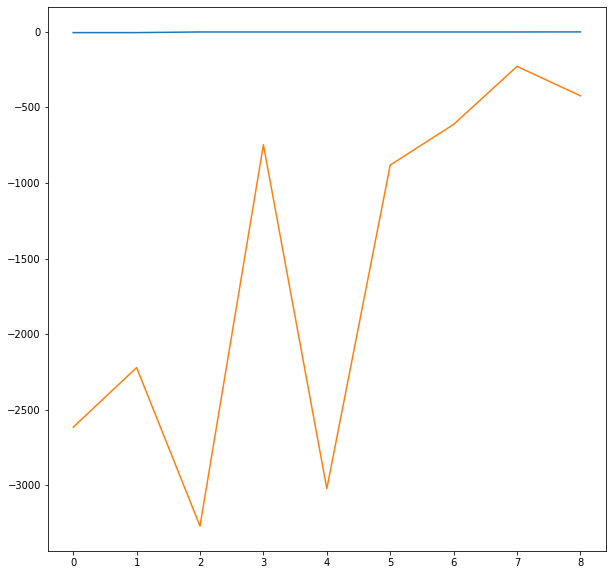

In [756]:
population = [generate_agent() for _ in range(100)]
max_fittnes_log, mean_fittnes_log, min_fittnes_log = evolve(
    population,
    fittnes,
    select_best_agents,
    crossover,
    mutation,
    mutation_probability=0.2, survival_probability=0.2, max_iterations=300,
    verbose=True, keep_best=False, plot=True
)

## Evaluation